In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

In [2]:
task = 'attack'

time: 1.38 ms


### Load Annotated Data

In [4]:
d_b, d_r = load_cf_data()

time: 15.4 s


In [5]:
l_b = plurality(d_b[task].dropna())
l_r = plurality(d_r[task].dropna())

time: 28.4 s


In [6]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 674 ms


### Split into train/dev and test

In [7]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 38.9 ms


In [8]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 6.83 ms


In [9]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 4.73 ms


In [10]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

15

time: 34.7 ms


### NGram Classification Pipeline

In [32]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (15000,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (1.0,5,10),
    'clf__class_weight': ('balanced', None)
}

time: 224 ms


### Hyper-Parameter tuning

In [11]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)


Best parameters set found:
{'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 5, 'vect__max_features': 15000, 'vect__ngram_range': (1, 5)} 0.897865356113


Grid scores:
0.89416 (+/-0.00037) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 1.0, 'vect__max_features': 15000, 'vect__ngram_range': (1, 6)}
0.89762 (+/-0.00003) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 1.0, 'vect__max_features': 15000, 'vect__ngram_range': (1, 5)}
0.89436 (+/-0.00122) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 5, 'vect__max_features': 15000, 'vect__ngram_range': (1, 6)}
0.89787 (+/-0.00078) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 5, 'vect__max_features': 15000, 'vect__ngram_range': (1, 5)}
0.89084 (+/-0.00155) for {'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'clf__C': 10, 'vect__max_features': 15000, 'vect__ngram_range': (1, 6)}
0.89407 (+/-0.00103) for {

In [11]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 1.0, class_weight = None)),
])

time: 2.27 ms


### Train on blocked

In [12]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 1min 3s


Eval on blocked


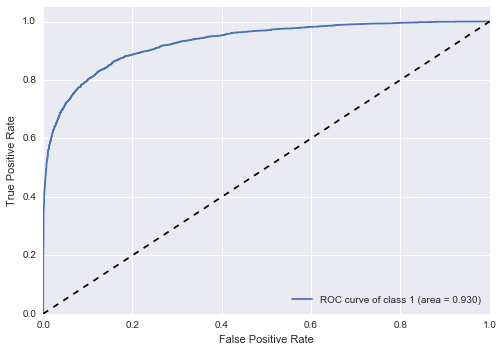

threshold @ optimal F1: 0.38265588432
{'optimal F1': '0.783',
 'precision @ optimal F1': '0.754',
 'recall @ optimal F1': '0.754',
 'roc': '0.930'}
time: 14.5 s


In [13]:
print('Eval on blocked')
_= eval_binary_classifier(b_model, b_test, calibration = False, roc = True)

Eval on random


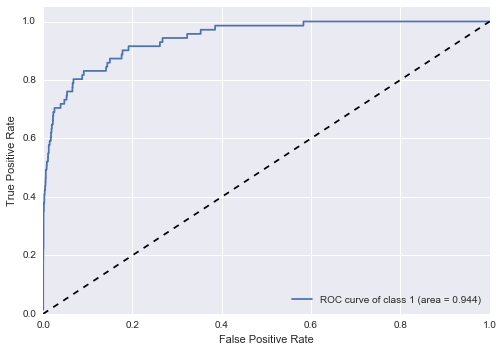

threshold @ optimal F1: 0.557368181171
{'optimal F1': '0.523',
 'precision @ optimal F1': '0.408',
 'recall @ optimal F1': '0.408',
 'roc': '0.944'}
time: 5.47 s


In [14]:
print('Eval on random')
_= eval_binary_classifier(b_model, r_test, calibration = False, roc = True)

### Train on random

In [15]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 24 s


Eval on blocked


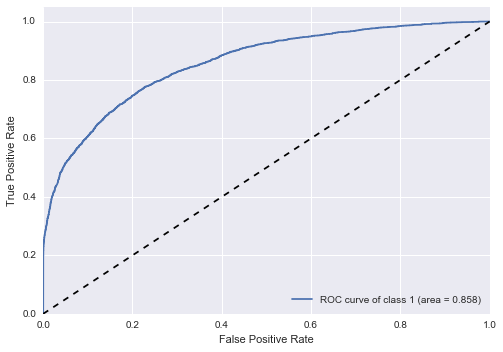

threshold @ optimal F1: 0.0393591886563
{'optimal F1': '0.666',
 'precision @ optimal F1': '0.688',
 'recall @ optimal F1': '0.688',
 'roc': '0.858'}
time: 14.4 s


In [16]:
print('Eval on blocked')
_= eval_binary_classifier(r_model, b_test, calibration = False, roc = True)

Eval on random


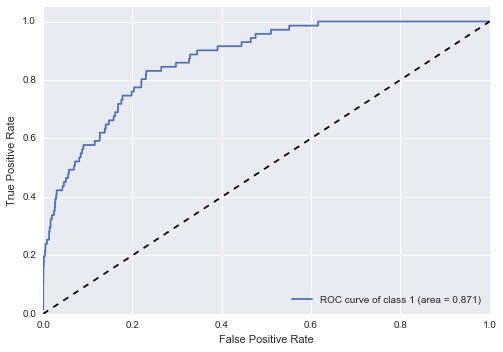

threshold @ optimal F1: 0.0697089481948
{'optimal F1': '0.306',
 'precision @ optimal F1': '0.239',
 'recall @ optimal F1': '0.239',
 'roc': '0.871'}
time: 5.49 s


In [17]:
print('Eval on random')
_= eval_binary_classifier(r_model, r_test, calibration = False, roc = True)

### Train on both

In [18]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 1min 23s


Eval on blocked


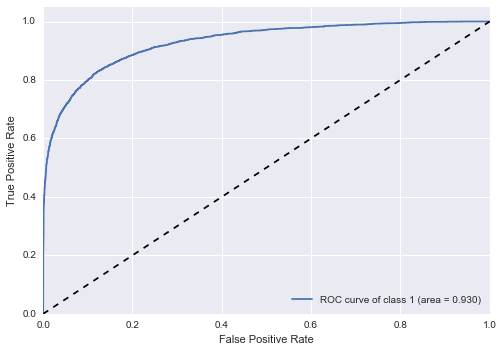

threshold @ optimal F1: 0.334822351078
{'optimal F1': '0.781',
 'precision @ optimal F1': '0.766',
 'recall @ optimal F1': '0.766',
 'roc': '0.930'}
time: 15.4 s


In [19]:
print('Eval on blocked')
_= eval_binary_classifier(br_model, b_test, calibration = False, roc = True)

Eval on random


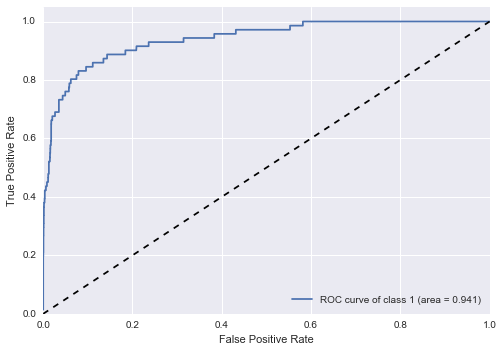

threshold @ optimal F1: 0.523232118973
{'optimal F1': '0.505',
 'precision @ optimal F1': '0.394',
 'recall @ optimal F1': '0.394',
 'roc': '0.941'}
time: 5.39 s


In [20]:
print('Eval on random')
_= eval_binary_classifier(br_model, r_test, calibration = False, roc = True)

Eval on both


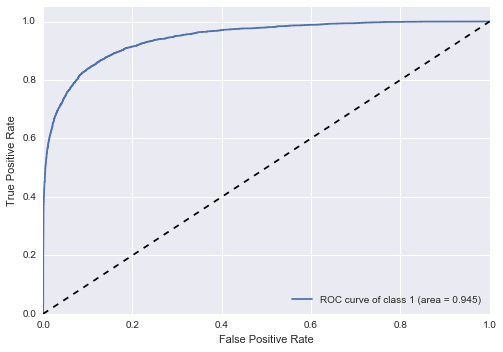

threshold @ optimal F1: 0.34137885851
{'optimal F1': '0.773',
 'precision @ optimal F1': '0.756',
 'recall @ optimal F1': '0.756',
 'roc': '0.945'}
time: 19.3 s


In [21]:
print('Eval on both')
_= eval_binary_classifier(br_model, br_test, calibration = False, roc = True)

### Check Calibration

threshold @ optimal F1: 0.34137885851
{'optimal F1': '0.773',
 'precision @ optimal F1': '0.756',
 'recall @ optimal F1': '0.756',
 'roc': '0.945'}


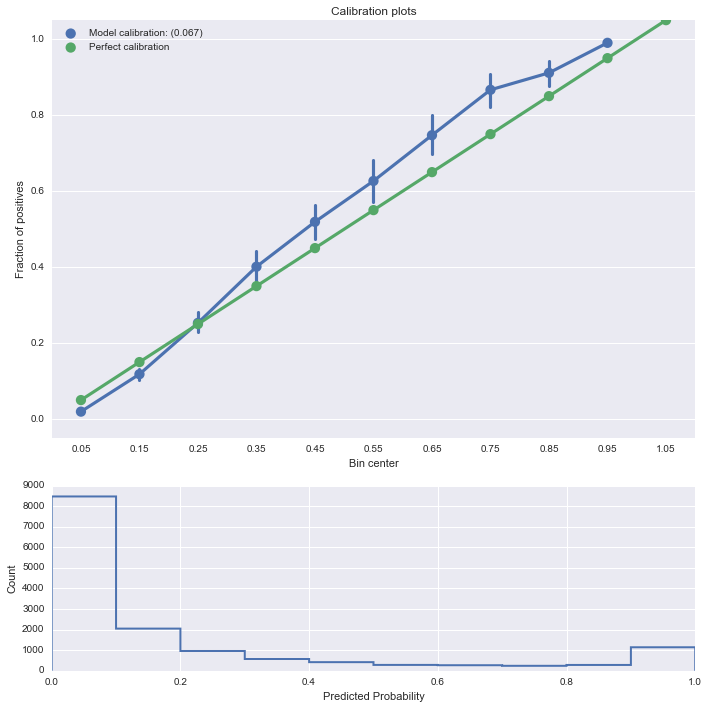

time: 19.8 s


In [22]:
_= eval_binary_classifier(br_model, br_test, calibration = True, roc = False)

threshold @ optimal F1: 0.523232118973
{'optimal F1': '0.505',
 'precision @ optimal F1': '0.394',
 'recall @ optimal F1': '0.394',
 'roc': '0.941'}


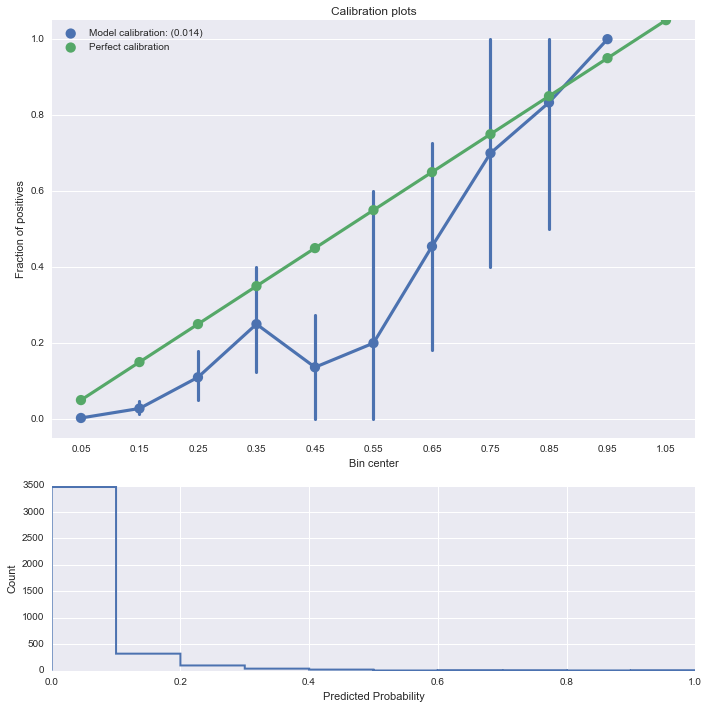

time: 6.33 s


In [26]:
_= eval_binary_classifier(br_model, r_test, calibration = True, roc = False)

### Error Analysis

In [23]:
fn, fp = get_clf_errors(br_model, br_test)

time: 35.9 s


In [24]:
# extreme False negatives
print_clf_errors(fn)

COMMENT:
" Please do not vandalize pages, as you did with this edit to Talk:Renewable resource. If you continue to do so, you will be blocked from editing.    "
SCORES: Actual: 1, Predicted: 0, Score: 0.01


COMMENT:
VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VO
SCORES: Actual: 1, Predicted: 0, Score: 0.01


COMMENT:
"Reply to your comments on my talk pageYour uncivil tone notwithstanding, I love being proved wrong, so please take this to Wikipedia:Deletion review.  IF you have a problem with my resolution, please submit to the appropriate

In [25]:
# extreme False positives
print_clf_errors(fp)

COMMENT:
 HOPE YOUR HEAD GETS CUT OFF AND SOMEONE WIPES THERE ASS WITH IT AND THEN STABS YOU IN YOUR HEART!!! NO ONE CAN KEEP ME FROM HERE YOU DUMB PIECE OF SHIT, NOT YAMLA'S STUPID ASS OR YOU!!! NOW HURRY UP AND SIT IN SOME TRAFFIC SO I CAN SEE YOUR HEAD ROLL DOWN THE STREET
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
 You Are an *****le!
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
BIGNOLE YOU ARE A BIG FAGGOT GET A LIFE AND STOP SPENDING ALL DAY ON WIKIPEDIA.  IT IS LIKE 1AM WHERE YOU ARE AND YOU HAVE NO LIFE.  PLEASE FALL OFF A CLIFF.  IF I EVER MEET YOU N THE STREET I WILL PEE ON YOU AND PUSH YOU INTO ONCOMING TRAIN TRAFFIC.  DON'T EVERY TOUCH MY PAGE AGAIN YOU FREAK OF NATURE
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
 Freak I seen your picture, you look like a faggot! Nice gums in your smile! You have big ears and looks like your balding. Get a tan and maybe you'll lose some of your pimples pizza face! Have you ever talk to a girl without givi

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked data as we add more training data.

In [33]:
def get_roc(model, test):
    return roc_auc_score(test['y'], model.predict_proba(test['x'])[:, 1])

time: 1.2 ms


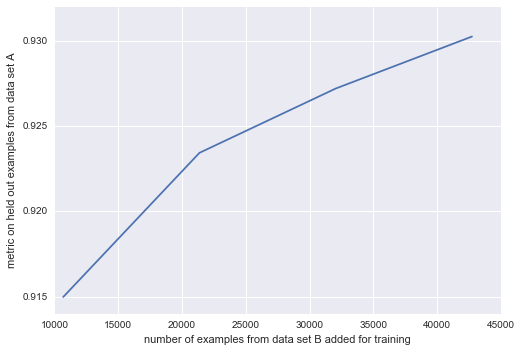

time: 3min 46s


In [35]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

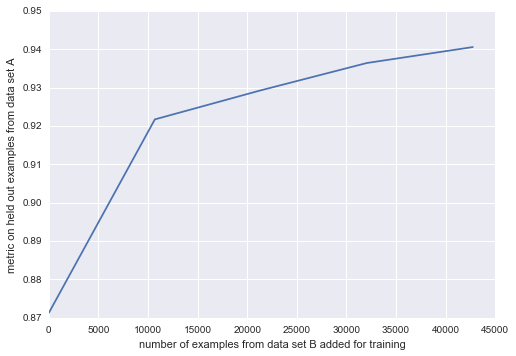

time: 5min 29s


In [36]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

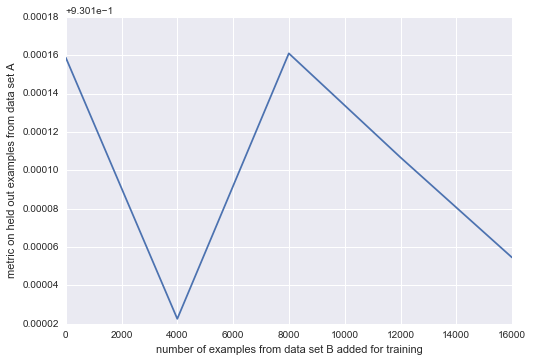

time: 7min 41s


In [37]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_roc)
plot_adding_other_data(ms, metrics)

# Final Model

In [38]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/attack_ngram.pkl',
 '../../models/attack_ngram.pkl_01.npy',
 '../../models/attack_ngram.pkl_02.npy',
 '../../models/attack_ngram.pkl_03.npy',
 '../../models/attack_ngram.pkl_04.npy',
 '../../models/attack_ngram.pkl_05.npy',
 '../../models/attack_ngram.pkl_06.npy']

time: 2min 7s
